In [294]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
from sklearn.mixture import GaussianMixture
import scipy.stats as ss

#from sympy import *
#from sympy.stats import *

In [295]:
gamma = 0.0138172

ribo_decay = 6.205e-6
prot_decay = 6.205e-6

r_R = 63
r_P = 63
l_R = 5000
l_P = 975

def LHS(regulates_X):
    
    pre_LHS = np.array([[0,1,0,0],
                        [0,0,1,0],
                        [0,0,0,1],
                        [0,0,0,0]])
    
    if int(regulates_X) == 0:
        prod_LHS = pre_LHS + np.array([[1,0,0,0],
                                       [0,0,0,0],
                                       [0,0,0,0],
                                       [0,0,0,0]])
    elif int(regulates_X) == 1:
        prod_LHS = pre_LHS + np.array([[0,0,0,0],
                                       [1,0,0,0],
                                       [0,0,0,0],
                                       [0,0,0,0]])
    elif int(regulates_X) == 2:
        prod_LHS = pre_LHS + np.array([[0,0,0,0],
                                       [0,0,0,0],
                                       [1,0,0,0],
                                       [0,0,0,0]])
    else: print('error: Regulates_X = {}'.format(regulates_X))
        
        
    
    #add decay reaction LHS
    return np.hstack((prod_LHS,np.eye(4)))

def RHS(regulates_X):
    
    pre_RHS = np.array([[1,1,0,0],
                        [0,1,1,0],
                        [0,0,1,1],
                        [0,0,0,1]])

    if int(regulates_X == 0):
        prod_RHS = pre_RHS + np.array([[1,0,0,0],
                                       [0,0,0,0],
                                       [0,0,0,0],
                                       [0,0,0,0]])
    elif int(regulates_X == 1):
        prod_RHS = pre_RHS + np.array([[0,0,0,0],
                                       [1,0,0,0],
                                       [0,0,0,0],
                                       [0,0,0,0]])
    elif int(regulates_X == 2):
        prod_RHS = pre_RHS + np.array([[0,0,0,0],
                                       [0,0,0,0],
                                       [1,0,0,0],
                                       [0,0,0,0]])
    
    else: print('error: Regulates_X = {}'.format(regulates_X))


    #add decay reaction RHS
    return np.hstack((prod_RHS,np.zeros((4,4))))


S = np.array([[ 1.,  0.,  0.,  0., -1.,  0.,  0.,  0.],
             [ 0.,  1.,  0.,  0.,  0., -1.,  0.,  0.],
             [ 0.,  0.,  1.,  0.,  0.,  0., -1.,  0.],
             [ 0.,  0.,  0.,  1.,  0.,  0.,  0., -1.]])


# def rates():
leakage = np.zeros(8)
dyn_range = np.repeat(100,8)
michaelis = np.repeat(400,8)
input_effect = 1
n = 2

    #1 means activation, 0 means repression
def hill_rates(X, regulates_X=0, net_code = 7, chemical_state=7):
    leakage = np.zeros(4)
    dyn_range = np.repeat(10,4)
    michaelis = np.repeat(40,4)
    decays = np.array([1e-4,1e-4,1e-4,1e-4])
    #input_effect = 1
    n = 2
    X_regulator = np.hstack( ([X[int(regulates_X)]], X[:-1]) )
    
    #transforms code into binary id
    edge_signs = np.array(list(format(net_code,'03b')), dtype='int') 
    switch = np.append(edge_signs, 0)
    
    #transforms state into binary id
    input_effect = np.append((np.array(list(format(chemical_state,'03b')), dtype='int'))*(-0.9) + 1, 1)
    
    production_rates = leakage + dyn_range * (((X_regulator/input_effect)**n) / (michaelis**n + (X_regulator/input_effect)**n))**switch * ((michaelis)**n / (michaelis**n + (X_regulator/input_effect)**n))**(1-switch)
    
    decay_rates = decays * X 
    
    return np.hstack((production_rates, decay_rates))


def dZ_dt(state, t=0, regulates_X=0, net_code = 7, chemical_state = 7):
    Z = state.reshape(2*S.shape[0]+1, S.shape[0])
    
    phi = np.atleast_2d(Z[0]).T
    F = hill_rates(X=phi.ravel(), regulates_X=regulates_X, net_code = net_code, chemical_state = chemical_state)
    E = S @ np.sqrt(np.diag(F))
    J = ( (1/phi @ np.atleast_2d(F) ) * LHS(regulates_X)).T
    A = S @ J
    
    V = Z[1:A.shape[0]+1]
    G = Z[A.shape[0]+1:]
    
    phidot = S @ F
    Vdot = A @ V + V @ A.T + E @ E.T
    
    Gdot = A @ G
    
    ode_list = np.vstack((phidot, Vdot, Gdot)).reshape(-1)
    
    return ode_list

In [296]:
class Trajectory:
    def get_init_counts(self, arr):
        # Linear scaling
        X = np.array
        return X

    def __init__(self, 
                 initial_counts= [10,10,10,10],
                 regulates_X = 0,
                 net_code = 7,
                 chemical_state = 7,
                 iterations=100):
        
        final_time = 10000
        
        self.iterations = iterations
        
        init_counts = np.array(initial_counts)
        init_cov    = np.eye(4)
        global_init = np.vstack([init_counts.reshape(1,4), init_cov, np.identity(4)])

        T = np.linspace(0, final_time, iterations)
        
        solved_odes = odeint(dZ_dt, y0=global_init.reshape(-1), args=(regulates_X,net_code, chemical_state), t=T).reshape(-1,2*S.shape[0]+1, S.shape[0])

        n_species = len(init_counts)
        self.X_t = solved_odes[:,0,:]
        self.V_t = solved_odes[:,1:n_species+1,:]
        self.G_t = solved_odes[:,n_species+1:,:]
        self.cov_t = self.V_t[0] @ self.G_t.transpose(0,2,1)

        #self.var_ribo = self.V_t[:,0,0]
        #self.var_prot = self.V_t[:,1,1]
        #self.cov_riboprot = self.V_t[:,0,1]

        #self.cov_ribo_over_time = self.cov_t[:,0,0]
        #self.cov_prot_over_time = self.cov_t[:,1,1]
        #self.cov_riboprot_over_time = self.cov_t[:,0,1]

        #self.rho_ribo = np.array([self.cov_ribo_over_time[t]/(np.sqrt(self.var_ribo[0])*np.sqrt(self.var_ribo[t])) for t in range(0,iterations)])
        #self.rho_prot = np.array([self.cov_prot_over_time[t]/(np.sqrt(self.var_prot[0])*np.sqrt(self.var_prot[t])) for t in range(0,iterations)])

        #self.mi_ribo = -0.5*np.log(1-self.rho_ribo**2)
        #self.mi_prot = -0.5*np.log(1-self.rho_prot**2)


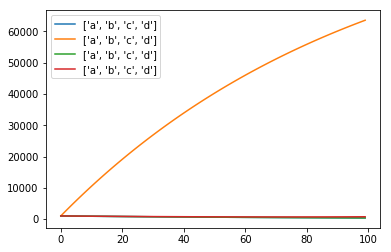

In [297]:
traj = Trajectory(initial_counts=[1000,1000,1000,1000], regulates_X=2, net_code=2)
plt.plot(traj.X_t, label=['a','b','c','d'])
plt.legend()
plt.show()

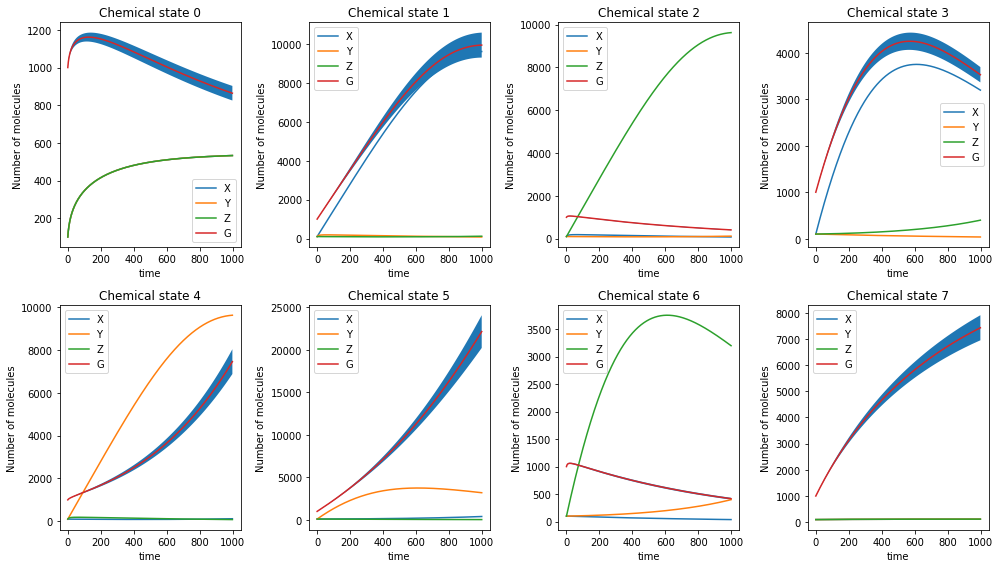

In [395]:
fig, axes = plt.subplots(2,4, figsize=(14,8))

for i,ax in enumerate(axes.ravel()):
    traj = Trajectory(initial_counts=[100,100,100,1000], regulates_X=2, net_code=0, chemical_state=i, iterations=1000)
    plot_traj = ax.plot(traj.X_t)
    ax.fill_between(range(traj.iterations), traj.X_t[:,3] - np.sqrt(traj.V_t[:,3,3]), traj.X_t[:,3] + np.sqrt(traj.V_t[:,3,3]))
    ax.legend(plot_traj, ['X','Y','Z','G'])
    ax.set_xlabel('time')
    ax.set_ylabel('Number of molecules')
    ax.set_title('Chemical state {}'.format(i))

#plt.yscale('log')

#plt.title('Entropy of G: {}'.format())
plt.tight_layout()
plt.show()

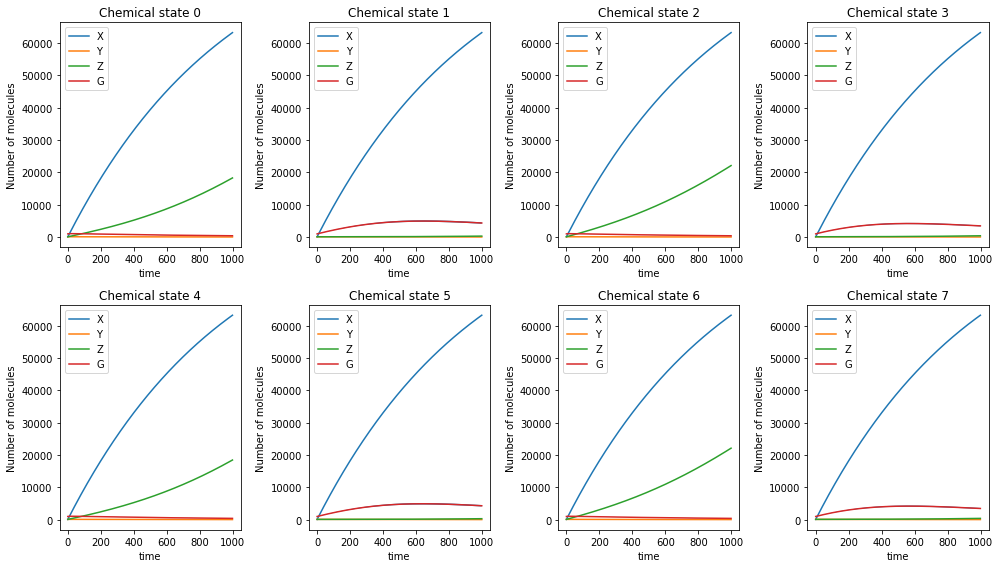

In [396]:
fig, axes = plt.subplots(2,4, figsize=(14,8))

for i,ax in enumerate(axes.ravel()):
    traj = Trajectory(initial_counts=[100,100,100,1000], regulates_X=0, net_code=4, chemical_state=i, iterations=1000)
    plot_traj = ax.plot(traj.X_t)
    ax.fill_between(range(traj.iterations), traj.X_t[:,3] - np.sqrt(traj.V_t[:,3,3]), traj.X_t[:,3] + np.sqrt(traj.V_t[:,3,3]))
    ax.legend(plot_traj, ['X','Y','Z','G'])
    ax.set_xlabel('time')
    ax.set_ylabel('Number of molecules')
    ax.set_title('Chemical state {}'.format(i))

plt.tight_layout()
plt.show()

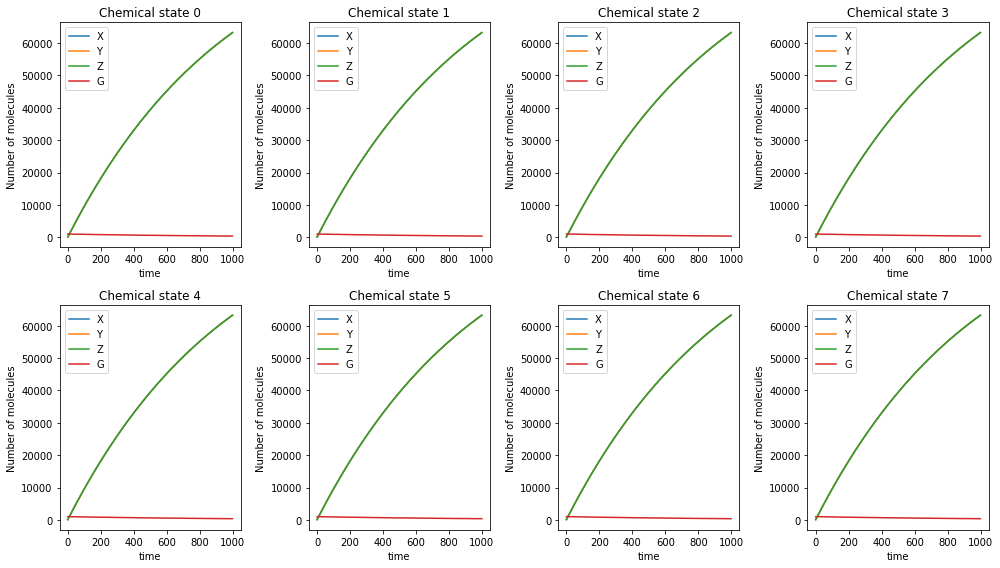

In [406]:
fig, axes = plt.subplots(2,4, figsize=(14,8))

for i,ax in enumerate(axes.ravel()):
    traj = Trajectory(initial_counts=[100,100,100,1000], regulates_X=2, net_code=7, chemical_state=i, iterations=1000)
    plot_traj = ax.plot(traj.X_t)
    ax.fill_between(range(traj.iterations), traj.X_t[:,3] - np.sqrt(traj.V_t[:,3,3]), traj.X_t[:,3] + np.sqrt(traj.V_t[:,3,3]))
    ax.legend(plot_traj, ['X','Y','Z','G'])
    ax.set_xlabel('time')
    ax.set_ylabel('Number of molecules')
    ax.set_title('Chemical state {}'.format(i))

plt.tight_layout()
plt.show()

In [408]:
traj = Trajectory(initial_counts=[100,100,100,1000], regulates_X=, net_code=7, chemical_state=i, iterations=1000)

In [305]:
net_1_5 = [Trajectory(initial_counts=[100,100,100,100], regulates_X=1, net_code=5, chemical_state=s, iterations=100000) for s in range(8)]
means_net = [net.X_t[-1,3] for net in net_1_5]
vars_net = [net.V_t[-1,3,3] for net in net_1_5]


In [306]:
means_net

In [301]:
ss.norm.pdf()

TypeError: pdf() missing 1 required positional argument: 'x'

In [ ]:
gmm = GaussianMixture(n_components= 8, covariance_type='spherical')


In [ ]:
gmm.means_ = np.array(means_net).reshape(-1,1)


gmm.weights_ = np.array([1/8]*8)#.reshape(-1,1)
gmm.covariances_ = np.array(vars_net).reshape(-1,1)
gmm.precisions_cholesky_ = 1/np.array(vars_net)

In [307]:
import sympy as sym
import sympy.stats as stats
sym.init_printing(use_unicode=False, wrap_line=False, no_global=True)

In [308]:
N = [stats.density(stats.Normal(name='N{}'.format(i), mean = m, std = np.sqrt(v)))(sym.Symbol('x')) for i,m,v in zip(range(8),means_net, vars_net)]

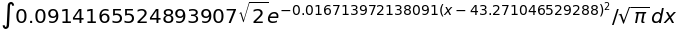

In [309]:
Integral(N[0])

In [348]:

mi_list 

In [356]:

def mutual_information(regulates_X=0, net_code=7):
    nets = [Trajectory(initial_counts=[100,100,100,100], regulates_X=regulates_X, net_code=net_code, chemical_state=s, iterations=100000) for s in range(8)]
    means_net = [net.X_t[-1,3] for net in nets]
    vars_net = [net.V_t[-1,3,3] for net in nets]

    conditional_entropy = np.mean(ss.norm.entropy(1, np.sqrt(vars_net)))
    N = [stats.density(stats.Normal(name='N{}'.format(i), mean = m, std = np.sqrt(v)))(sym.Symbol('x')) for i,m,v in zip(range(8),means_net, vars_net)]
    marginal_entropy = -1*sym.Integral(sum(N)/8 * sym.log(sum(N)/8, 2), ((sym.Symbol('x')), -sym.oo, sym.oo)).evalf()

    return marginal_entropy - conditional_entropy


In [407]:
%%time
mi_list = []

for x in range(1,3):
    for code in range(8):
        mi = mutual_information(x, code)
        print(mi)
        mi_list.append(mi)

In [350]:
mi_list

In [343]:
Trajecto